<h1>Denoising Autoencoders<br /><small>Jonah Williams</small></h1>

Given data X, an autoencoder tries to learning an efficient coding y that exploits the statistical regularities present in the training examples.  To do so, we construct a a multilayer perceptron where the output layer is the same dimension as the input layer and measure the loss with respect to the original datum.

\begin{align}
y &= \sigma(x W + b) \\
z &= \sigma(y W' + b')
\end{align}
Note that we constrain the weight matrix $W'$ to be the transpose of $W$. If the output is continuous we could use squared loss, or for probabilities the cross entropy loss.
\begin{align}
L(x, \ z \ | \ W, \ b, \ b') &= | \ x - z \ |^2\\
L(x, \ z \ | \ W, \ b, \, b') &= \sum_{k=1}^d x_k log(z_k)
\end{align}



In [4]:
import theano
import theano.tensor as T
import numpy as np
import cPickle
import gzip
import urllib
import matplotlib.pyplot as plt
%matplotlib inline

dataset = "mnist.pkl.gz"
origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
print 'Downloading data from %s' % origin
urllib.urlretrieve(origin, dataset)


f = gzip.open(dataset, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [5]:
train_set_x = theano.shared(np.asarray(train_set[0], dtype=theano.config.floatX), borrow=True)
valid_set_x = theano.shared(np.asarray(valid_set[0], dtype=theano.config.floatX), borrow=True)
test_set_x = theano.shared(np.asarray(test_set[0], dtype=theano.config.floatX), borrow=True)

In [6]:
class Autoencoder(object):
    
    def __init__(self, n_visible, n_hidden, input=None, W=None, b=None, b_prime=None):
        
        if not W:
            initial_W = np.asarray(
                np.random.uniform(
                    low=-4 * np.sqrt(6. / (n_visible + n_hidden)),
                    high=4 * np.sqrt(6. / (n_visible + n_hidden)),
                    size=(n_visible, n_hidden)
                ), dtype=theano.config.floatX)
            W = theano.shared(value=initial_W, name='W', borrow=True)
        if not b:
            b = theano.shared(
                value=np.zeros(n_visible, dtype=theano.config.floatX),
                name='b', borrow=True)
        if not b_prime:
            b_prime = theano.shared(
                value=np.zeros(n_hidden, dtype=theano.config.floatX),
                name='b_prime', borrow=True)
            
        self.W = W
        self.W_prime = self.W.T
        self.b = b
        self.b_prime = b_prime
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.x = input
            
        self.params = [self.W, self.b, self.b_prime]
        
    def hidden_values(self, input):
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b_prime)
    
    def output_values(self, hidden):
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b)
    
    def cost_update(self, learning_rate=0.01):
        y = self.hidden_values(self.x)
        z = self.output_values(y)
        
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        cost = T.mean(L)
        
        gparams = T.grad(cost, self.params)
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)]

        return (cost, updates)  

In [7]:
index = T.lscalar()
x = T.matrix('x')
batch_size = 10
    
auto = Autoencoder(n_visible=784, n_hidden=100, input=x)
cost, updates = auto.cost_update(learning_rate=0.1)

train = theano.function([index], cost, updates=updates,
        givens={x: train_set_x[index * batch_size: (index + 1) * batch_size]})
valid = theano.function([], cost,
        givens={x: valid_set_x})
test = theano.function([], cost,
        givens={x: test_set_x})


In [8]:
batches = 5000
epochs = 10
current = 0
validation_loss = []
training_loss = []
while current < epochs:
    for i in xrange(batches):
        training_loss.append(train(i))
    valid_loss = valid()
    print valid_loss
    validation_loss.append(valid_loss)
    current += 1
    print str(current) + "/" + str(epochs)

78.5590155304
1/10
75.6853897313
2/10
74.6139167535
3/10
73.8503312192
4/10
73.3270865385
5/10
72.9007337822
6/10
72.5375345663
7/10
72.1986174366
8/10
71.9405788552
9/10
71.7734946388
10/10


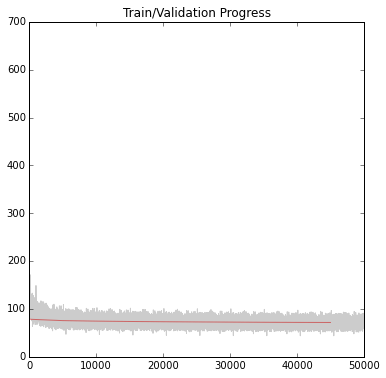

In [9]:
plt.figure(figsize=(6, 6))
plt.plot([i * batches for i in xrange(epochs)], validation_loss, alpha=0.5, color="red")
plt.plot([i for i in xrange(epochs * batches)], training_loss, alpha=0.2, color="black", linewidth=1)
plt.title("Train/Validation Progress")
plt.show()

In [10]:
test()

array(71.30511831406366)

<h2>Resulting Filters</h2>
We can manually inspect how our autoencoder is working by looking at the resulting filters generated by activating a datum of the form $X = [1, 1, 1,...,1]$ - This shows us the region that each hidden unit is activated most strongly by.

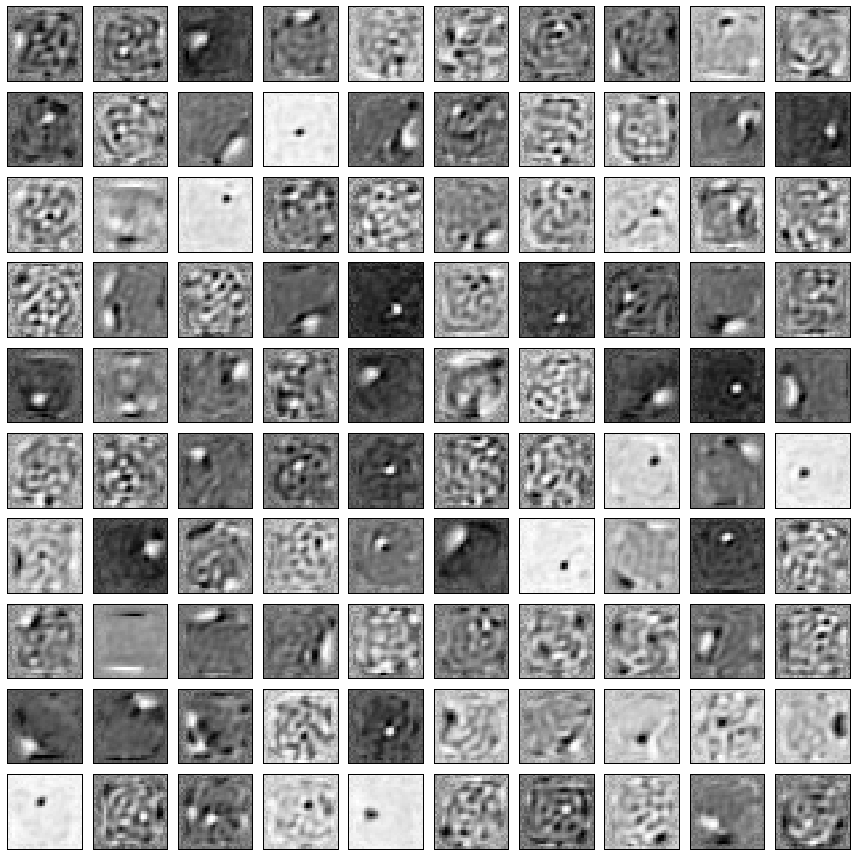

In [11]:
dummy = np.ones(shape=(784, 100))
weights = auto.W.get_value()
y = dummy * weights
y = (y - np.max(y)) / (np.max(y) - np.min(y))
fig, ax = plt.subplots(10, 10)
fig.set_size_inches(12, 12)
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())

for i in xrange(10):
    for j in xrange(10):
        ax[i, j].imshow(y[:,(i * 10) + j].reshape(28, 28), interpolation="nearest", cmap="Greys")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.show()

<h3>Adding Stochastic Noise</h3>
One method of improving the ability of autoencoders to generalize is to add noise to the input data, often in the form of setting some random elements to zero.  We can build this feature into our autoencoder class by modifying the cost_updates function

In [12]:
from theano.tensor.shared_randomstreams import RandomStreams

class Autoencoder(object):
    
    def __init__(self, n_visible, n_hidden, input=None, W=None, b=None,
                 b_prime=None, np_rng=None, theano_rng=None):
        
        if not np_rng:
            np_rng = np.random.RandomState(12345)
        if not theano_rng:
            theano_rng = RandomStreams(np_rng.randint(12312312))

        if not W:
            initial_W = np.asarray(
                np_rng.uniform(
                    low=-4 * np.sqrt(6. / (n_visible + n_hidden)),
                    high=4 * np.sqrt(6. / (n_visible + n_hidden)),
                    size=(n_visible, n_hidden)
                ), dtype=theano.config.floatX)
            W = theano.shared(value=initial_W, name='W', borrow=True)
        if not b:
            b = theano.shared(
                value=np.zeros(n_visible, dtype=theano.config.floatX),
                name='b', borrow=True)
        if not b_prime:
            b_prime = theano.shared(
                value=np.zeros(n_hidden, dtype=theano.config.floatX),
                name='b_prime', borrow=True)
            
        self.W = W
        self.W_prime = self.W.T
        self.b = b
        self.b_prime = b_prime
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.x = input
        self.np_rng = np_rng
        self.theano_rng = theano_rng
            
        self.params = [self.W, self.b, self.b_prime]
        
    def hidden_values(self, input):
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b_prime)
    
    def output_values(self, hidden):
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b)
    
    def mask_input(self, input, noise_level):
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - noise_level,
                                        dtype=theano.config.floatX) * input
    
    def cost_update(self, noise_level=0, learning_rate=0.01):
        noisy_x = self.mask_input(self.x, noise_level)
        y = self.hidden_values(noisy_x)
        z = self.output_values(y)
        
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        cost = T.mean(L)
        
        gparams = T.grad(cost, self.params)
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)]

        return (cost, updates)

In [13]:
auto = Autoencoder(n_visible=784, n_hidden=100, input=x)
cost, updates = auto.cost_update(learning_rate=0.1, noise_level=0.3)

train = theano.function([index], cost, updates=updates,
        givens={x: train_set_x[index * batch_size: (index + 1) * batch_size]})
valid = theano.function([], cost,
        givens={x: valid_set_x})
test = theano.function([], cost,
        givens={x: test_set_x})

In [14]:
batches = 5000
epochs = 10
current = 0
validation_loss = []
training_loss = []
while current < epochs:
    for i in xrange(batches):
        training_loss.append(train(i))
    valid_loss = valid()
    print valid_loss
    validation_loss.append(valid_loss)
    current += 1
    print str(current) + "/" + str(epochs)

86.8540182166
1/10
83.340646344
2/10
81.3631954845
3/10
80.2726893313
4/10
79.3666038349
5/10
79.0721375739
6/10
78.6471149736
7/10
78.346952394
8/10
77.9047254479
9/10
77.7152999366
10/10


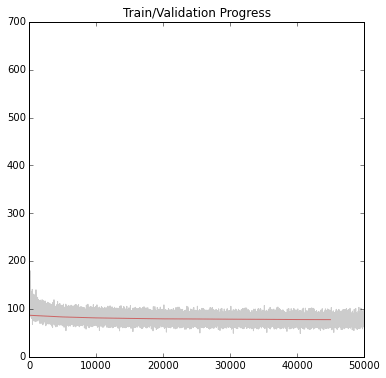

In [15]:
plt.figure(figsize=(6, 6))
plt.plot([i * batches for i in xrange(epochs)], validation_loss, alpha=0.5, color="red")
plt.plot([i for i in xrange(epochs * batches)], training_loss, alpha=0.2, color="black", linewidth=1)
plt.title("Train/Validation Progress")
plt.show()

In [16]:
test()

array(77.27382717149054)

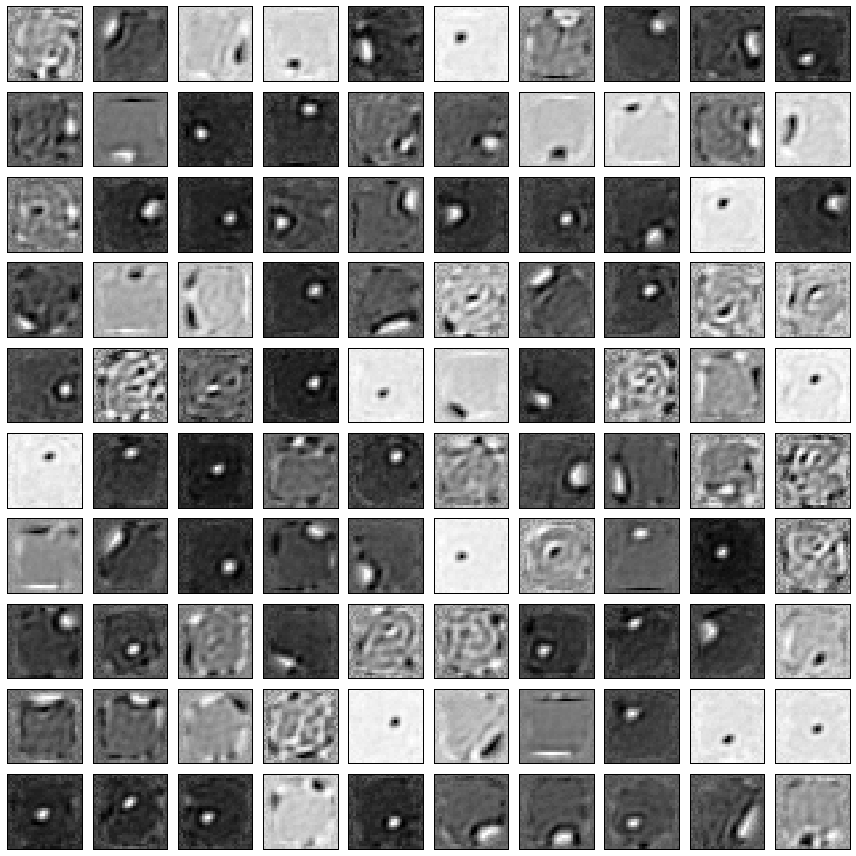

In [17]:
dummy = np.ones(shape=(784, 100))
weights = auto.W.get_value()
y = dummy * weights
y = (y - np.max(y)) / (np.max(y) - np.min(y))
fig, ax = plt.subplots(10, 10)
fig.set_size_inches(12, 12)
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())

for i in xrange(10):
    for j in xrange(10):
        ax[i, j].imshow(y[:,(i * 10) + j].reshape(28, 28), interpolation="nearest", cmap="Greys")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.show()

In [18]:
As we can see above, the filters are a lot smoother!

SyntaxError: invalid syntax (<ipython-input-18-acaf7d6a5c22>, line 1)